# Glider Sampling
Make a plot showing some of the sampling properties of the two gliders at samll scales.

In [10]:
from scipy.io import loadmat
import numpy as np
import xarray as xr

import glidertools as gt
import matplotlib.pylab as plt
from matplotlib.colors import BoundaryNorm

from cmocean import cm as cmo

import gsw

import extra_funcs as ef

In [2]:
plt.style.use('seaborn-colorblind')
plt.rcParams['font.size'] = 12

In [3]:
# Edit this to be the path where the nc files downloaded from the location 
# in the read me are stored. 
data_dir = '/Users/dhruvbalwada/OneDrive/sogos_data'
nc_files_659 = data_dir + '/data/raw/gliders/SOGOS_Apr19/sg659/*.nc'
nc_files_660 = data_dir + '/data/raw/gliders/SOGOS_Apr19/sg660/*.nc'

In [4]:
def create_point_wise(nc_files_path):
    var_names = [
        'ctd_depth',
        'ctd_pressure',
        'salinity',
        'temperature'
    ]

    ds_dict = gt.load.seaglider_basestation_netCDFs(
        nc_files_path, var_names,
        return_merged=False,
        keep_global_attrs=False
    )

    ctd = ds_dict['ctd_data_point']
    # throw out data points after we stopped sampling the region for science
    # and the gliders were being turned on just so they could get back to be picked by a ship. 
    ctd = ctd.where(ctd.longitude<40, drop=True) 
    
    return ctd

In [5]:
ctd_659  = create_point_wise(nc_files_659)


DIMENSION: ctd_data_point
{ctd_time, salinity, ctd_depth, longitude, temperature, ctd_pressure, latitude}


100%|██████████| 492/492 [00:03<00:00, 133.15it/s]


In [8]:
ctd_660  = create_point_wise(nc_files_660)


DIMENSION: ctd_data_point
{ctd_time, salinity, ctd_depth, longitude, temperature, ctd_pressure, latitude}


100%|██████████| 541/541 [00:03<00:00, 138.17it/s]


In [12]:
ctd_659['days'] = ef.datetime2ytd(ctd_659.ctd_time_dt64)
ctd_660['days'] = ef.datetime2ytd(ctd_660.ctd_time_dt64)

dist_659 = gt.utils.distance(ctd_659.longitude, 
                       ctd_659.latitude)

ctd_659['distance'] = xr.DataArray(np.cumsum(dist_659), 
                           dims= ['ctd_data_point'])

dist_660 = gt.utils.distance(ctd_660.longitude, 
                       ctd_660.latitude)

ctd_660['distance'] = xr.DataArray(np.cumsum(dist_660), 
                           dims= ['ctd_data_point'])

In [ ]:
dist_659_surf = ctd_659.distance.where(ctd_659.ctd_pressure<50).groupby(ctd_659.dives).mean()
dist_659_mid = ctd_659.distance.where(ctd_659.ctd_pressure<525).where(ctd_659.ctd_pressure>475).groupby(ctd_659.dives).mean()
dist_659_bottom = ctd_659.distance.where(ctd_659.ctd_pressure>950).groupby(ctd_659.dives).mean()

dist_660_surf = ctd_660.distance.where(ctd_660.ctd_pressure<50).groupby(ctd_660.dives).mean()
dist_660_mid = ctd_660.distance.where(ctd_660.ctd_pressure<525).where(ctd_660.ctd_pressure>475).groupby(ctd_660.dives).mean()
dist_660_bottom = ctd_660.distance.where(ctd_660.ctd_pressure>950).groupby(ctd_660.dives).mean()

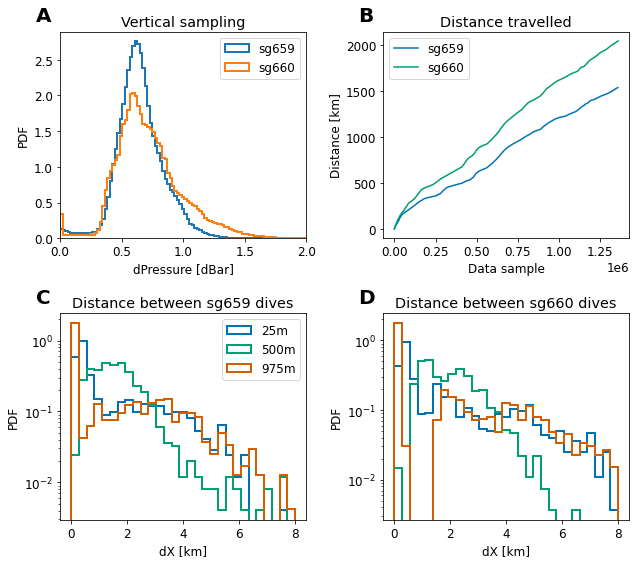

In [53]:
import string
fig, axs = plt.subplots(2,2,figsize=(9,8))
axs = axs.flat

np.abs(ctd_659.ctd_pressure.diff('ctd_data_point')).plot.hist(ax=axs[0], bins=np.linspace(0,2,100), 
                                                         histtype='step', color='tab:blue',
                                                        density=True, label='sg659',
                                                        linewidth=2);
np.abs(ctd_660.ctd_pressure.diff('ctd_data_point')).plot.hist(ax=axs[0], bins=np.linspace(0,2,100), 
                                                         histtype='step', color='tab:orange',
                                                        density=True, label='sg660',
                                                        linewidth=2);

axs[0].legend()

axs[0].set_xlim([0, 2])
axs[0].set_ylabel('PDF')
axs[0].set_xlabel('dPressure [dBar]')
axs[0].set_title('Vertical sampling')
axs[0].text(-0.1, 1.05, 'A', transform=axs[0].transAxes, 
            size=20, weight='bold')


(ctd_659['distance']/1e3).plot(ax = axs[1], label='sg659')
(ctd_660['distance']/1e3).plot(ax = axs[1], label='sg660')
axs[1].legend()
axs[1].set_ylabel('Distance [km]')
axs[1].set_xlabel('Data sample')
axs[1].set_title('Distance travelled')
axs[1].text(-0.1, 1.05, 'B', transform=axs[1].transAxes, 
            size=20, weight='bold')


(dist_659_surf/1e3).diff('dives').plot.hist(ax=axs[2], bins = np.linspace(0,8,30), 
                                      density=True, histtype='step', linewidth=2,
                                           label='25m');

(dist_659_mid/1e3).diff('dives').plot.hist(ax=axs[2],bins = np.linspace(0,8,30), 
                                      density=True, histtype='step', linewidth=2,
                                          label='500m');

(dist_659_bottom/1e3).diff('dives').plot.hist(ax=axs[2], bins = np.linspace(0,8,30), 
                                      density=True, histtype='step', linewidth=2,
                                             label='975m');

axs[2].set_xlabel('dX [km]')
axs[2].set_ylabel('PDF')
axs[2].set_yscale('log')
axs[2].set_title('Distance between sg659 dives')
axs[2].legend()
axs[2].text(-0.1, 1.05, 'C', transform=axs[2].transAxes, 
            size=20, weight='bold')



(dist_660_surf/1e3).diff('dives').plot.hist(ax = axs[3], bins = np.linspace(0,8,30), 
                                      density=True, histtype='step', linewidth=2,
                                           label='25m');

(dist_660_mid/1e3).diff('dives').plot.hist(ax = axs[3], bins = np.linspace(0,8,30), 
                                      density=True, histtype='step', linewidth=2,
                                          label='500m');

(dist_660_bottom/1e3).diff('dives').plot.hist(ax = axs[3], bins = np.linspace(0,8,30), 
                                      density=True, histtype='step', linewidth=2,
                                             label='975m');

axs[3].set_xlabel('dX [km]')
axs[3].set_ylabel('PDF')
axs[3].set_yscale('log')
axs[3].set_title('Distance between sg660 dives')
axs[3].text(-0.1, 1.05, 'D', transform=axs[3].transAxes, 
            size=20, weight='bold')


plt.tight_layout()

plt.savefig('sampling_properties.pdf')